# Object Detection with Detectron 2 - PyTorch 🔥🔥

![Detectron2](https://miro.medium.com/max/4000/0*VbMjGBHMC6GnDKUp.png)

**In this notebook we'll be checking out the new object detection framework "Detectron2" within PyTorch. It allows us to quickly build object detection models.**

*Note: This notebook is a work in progress. I will keep on extending this notebook to fully explain and explore all the capabilities of the "Detectron2"- framework!*



## Table of contents
* 1.[Introduction](#intro)
* 2.[Installing dependencies and libraries](#import)
* 3.[Loading & using existing model](#loadmodel)
    * 3.1.[The base data](#basedata)
    * 3.2.[The model zoo](#modelzoo)
    * 3.3.[Inference with a pretrained model](#pretrainedinference)
* 4.[Train with custom data](#trainmodel)
    * 4.1.[Download the dataset](#downloaddataset)
    * 4.2.[Helper functions](#helperfunction)
    * 4.3.[Training](#traincustom)
    * 4.4.[Model evaluation](#modelevaluation)
* 5.[Other models](#othermodels)
    * 5.1.[Keypoint detection](#keypoint)
    * 5.2.[Panoptic segmentation](#panoptic)
    * 5.3.[Semantic, Densepose, ...](#semantic)
* 6.[Video](#video)
    * 6.1.[Libraries](#videolib)
    * 6.2.[The video](#thevideo)
    * 6.3.[Inferencing](#videoinference)

<a id=intro ></a>
# 1. Introduction
[Detectron2](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/) is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron that started from maskrcnn-benchmark.

This platform is implemented in PyTorch. Thanks to its modular design its a very flexible and extensible framework providing fast training.

It includes implementations of state-of-the-art object detection algorithms such as:
* Box detection
* Mask detection
* KeyPoint detection
* Densepose detection
* Semantic segmentation
* Panoptic segmentation

In this notebook we'll have a look at several of these implementations and show how you can use custom datasets to train your own customer model.

*Note: This notebook is a work in progress. I will keep on extending this notebook to fully explore all the capabilities of the "Detectron2"- framework!*
*Future updates will consist in adding more high-end object detection algorithms and explaining more of the functions within the framework.*

<a id=import ></a>
# 2. Installing dependencies and libraries

We can use both CPU and GPU for training and inference of the models.

Running on CPU:

In [1]:
# !pip install -q -U torch torchvision -f https://download.pytorch.org/whl/torch_stable.html 
# !pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# !pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/index.html

Running on GPU:

In [2]:
# # Helper function, used these for debugging purposes
# # detector2 build only succeeds if CUDA version is correct

# #!nvidia-smi
# #!nvcc --version

# #import torch
# #torch.__version__
# #import torchvision
# #torchvision.__version__

# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
     |████████████████████████████████| 6.8 MB 4.6 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210204-py3-none-any.whl size=44943 sha256=edfc13d4e937e5bfad173e39fd4d127b4599a2cf6fa6e4baa2d6f2abcf8871cb
  Stored in directory: /root/.cache/pip/wheels/0a/f2/8c/124367ec901d4b48b5ba4c0226c0a8239815b4e969ad15cc7a
  Created wheel for iopath: filename=iopath-0.1.3-py3-none-any.whl size=11169 sha256=30131fc6abc41ce9e54611af6b6ff04f2b3f10b83725b922fa4ea2443217b07d
  Stored in directory: /root/.cache/pip/wheels/33/44/20/06445612ad8cf4ad6250aee85516e9499d5a49151ef5358164
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272644 sha256=d56890e3fcf3ff7606c5f9ddc24d1db60f4a5796366901c0a50efc8d6e072630
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built fvcore iopath pycocotools

Underneed you'll find the extra libraries we'll use in this notebook. More libraries will be added througout the notebook when needed.

In [1]:
%cd ..

c:\Users\M\Documents\LifeLongLearning\ai_projects\detectron2


In [2]:
# Base setup:
# detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

# detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

<a id="loadmodel" ></a>
# 3. Loading and using an existing model

In this chapter we'll have a look at a pretrained model and the base data it's trained on. Later on we'll do some inference with it.

<a id="basedata" ></a>
## 3.1. The base data

The model we'll be using is pretrained on the [COCO](https://cocodataset.org/#home) dataset (2017). This dataset contains a lot of labeled data people can use to train there Object detection models on. (Object, Keypoint, Panoptic, Instance and Densepose detectors) 

Let's take a look at a sample:

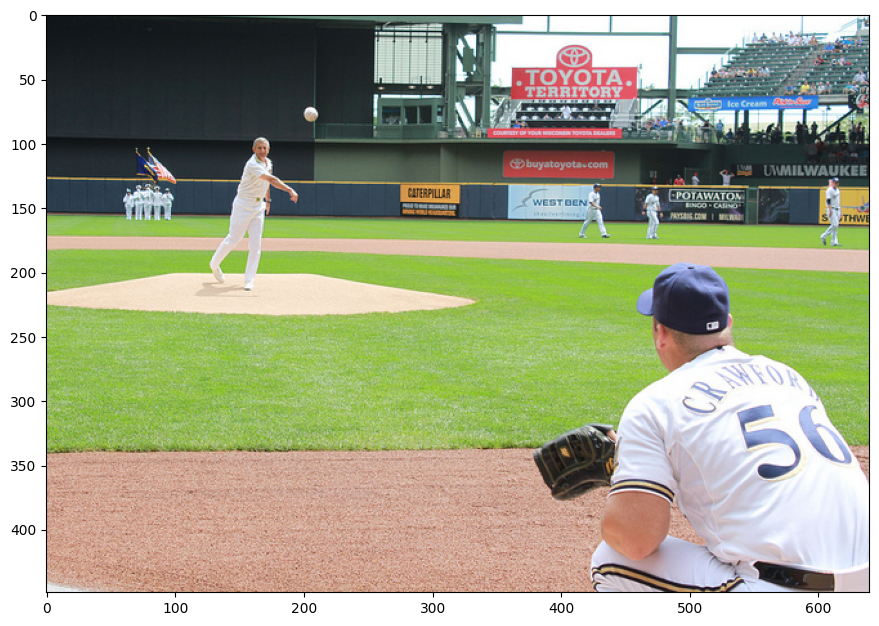

In [3]:
!wget http://images.cocodataset.org/val2017/000000282037.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

plt.figure(figsize=(15,7.5))
plt.imshow(im[..., ::-1]) #bgr to rgb

<a id="modelzoo"></a>
## 3.2. The model zoo
Many pretrained models can be found back within the "[modelzoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md)". This is a collection of models pretrained on a certain dataset that are ready to be used. Mostly people will use the pretrained weights of these model for initalization of there own custom model. This significantly shortens the training time and performance. And that's exactly what we'll be doing!

The model we'll be using can be found [here](https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml). 

How does it work?
As we can find [here](https://www.researchgate.net/figure/Our-Mask-R-CNN-framework-In-the-first-stage-we-use-Resnet50-Resnet101-and-Resnet_fig1_334011187):
> Region proposal network (RPN) utilizes feature maps at one of the intermediate layers (usually the last convolutional layer) of the CNN feature extractor networks to generate box proposals (300 boxes in our study). The proposed boxes are a grid of anchors tiled in different aspect ratios and scales. The second stage predicts the confidence value, the offsets for the proposed box and the mask within the box for each anchor.
Source publication

![Mask R-CNN Resnet](https://www.researchgate.net/profile/Hemin_Ali_Qadir/publication/334011187/figure/fig1/AS:774289183735808@1561616335154/Our-Mask-R-CNN-framework-In-the-first-stage-we-use-Resnet50-Resnet101-and-Resnet.ppm)

Alright, so now that we know how our model works lets test it out!

<a id="pretrainedinference"></a>
## 3.3. Inference with a pretrained model

In this first "coding" part are two important utils from Detector2. On the one hand we are using **cfg** or better [configs](https://detectron2.readthedocs.io/en/latest/tutorials/configs.html) which represents the complete configuration of a object detection model. These configurations are stored within a YAML-file and can be easily received from the modelzoo.

After the configuration is complete we'll use the [**DefaultPredictor**](https://detectron2.readthedocs.io/en/latest/tutorials/models.html?highlight=DefaultPredictor#use-a-model) class to make predictions.

In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE = "cpu"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im[..., ::-1])

c:\Users\M\Documents\LifeLongLearning\ai_projects\detectron2\detectron2\model_zoo\configs\COCO-InstanceSegmentation\mask_rcnn_R_50_FPN_3x.yaml
[06/26 11:08:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


c:\Users\M\anaconda3\envs\detectron2\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The output of the predictions is saved within the outputs variable. See [model output format](https://detectron2.readthedocs.io/tutorials/models.html#model-output-format) for all the available functions. 

In [6]:
print(outputs["instances"].pred_classes)
# print(outputs["instances"].pred_boxes)

tensor([ 0,  0,  0,  0,  0, 35, 32,  0,  0,  0,  0,  0])


In the output above we see an array which shows us the predictions made by the model. But what number stands for which class?

Every dataset is associated with [metadata](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#metadata-for-datasets). It is a key-value mapping that contains information about the dataset. It can be used to further interpret the dataset. This information can later be used for data augmentation, evaluation, visualization, logging, ... .

In [7]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

namespace(name='coco_2017_train',
          json_file='datasets\\coco/annotations/instances_train2017.json',
          image_root='datasets\\coco/train2017',
          evaluator_type='coco',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             13: 11,
                                             14: 12,
                                             15: 13,
                                             16: 14,
                                 

For example you can find which objects it can recognize:

In [8]:
import pandas as pd
modelclasses = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
df = pd.DataFrame(modelclasses,columns=['Model classes'])
df

Model classes
0         person
1        bicycle
2            car
3     motorcycle
4       airplane
..           ...
75          vase
76      scissors
77    teddy bear
78    hair drier
79    toothbrush

[80 rows x 1 columns]

Now that we know each label through the metadata. Let's visualize the result of the pretrained model from the modelzoo. For this we'll use the [**Visualizer**](https://detectron2.readthedocs.io/en/latest/modules/utils.html#module-detectron2.utils.visualizer) class.

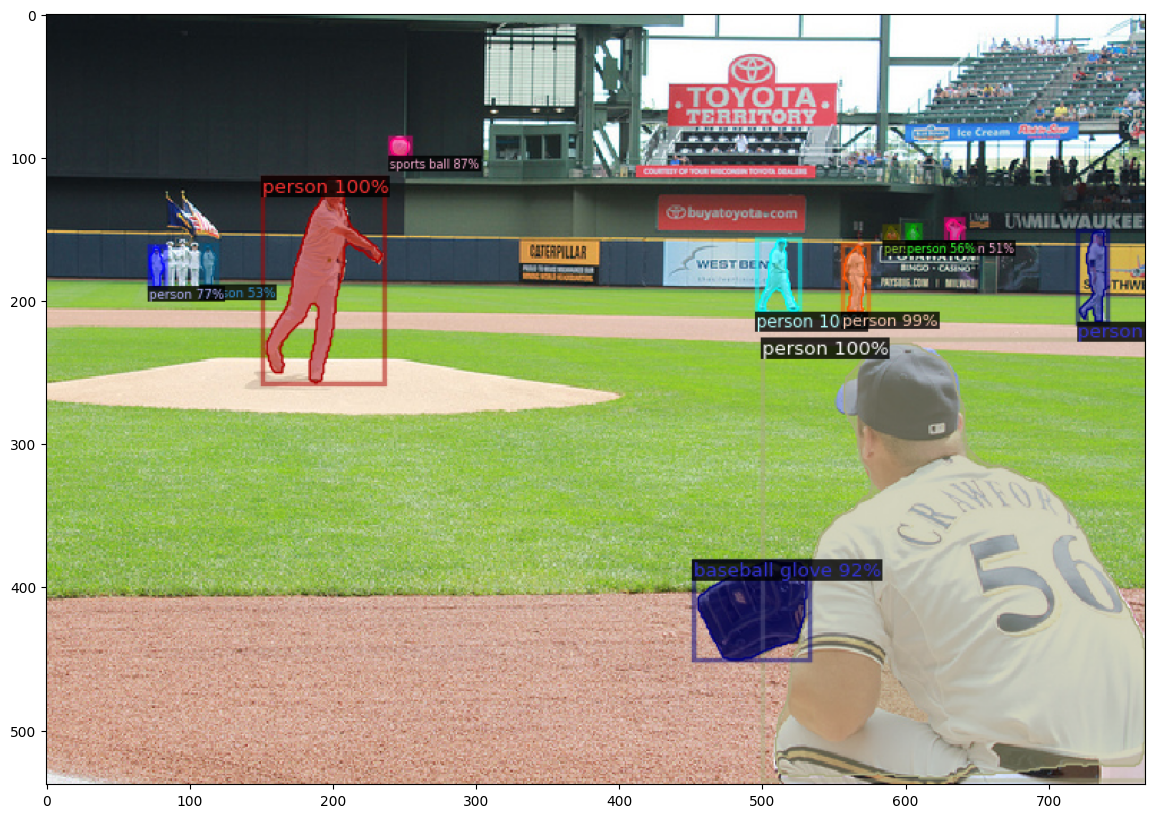

In [9]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(out.get_image()[..., ::-1][..., ::-1])

<a id=trainmodel > </a>
# 4. Train on a custom dataset

Alright so it's pretty easy to run an existing model. Let's now train the model with our own data!

<a id=downloaddataset > </a>
## 4.1. Download the dataset

Without data we are nothing. So let's download our dataset!

In [17]:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip

<a id=helperfunction > </a>
## 4.2. Helper functions

Let's create some helper functions.

The **get_balloon_dicts()** will convert our data to the correct format. The [**BoxMode**](https://detectron2.readthedocs.io/en/latest/modules/structures.html?highlight=BoxMode#detectron2.structures.BoxMode) can be used to get the structure.

Afterwards we'll have to add or register our new dataset with [**DatasetCatalog.register()**](https://detectron2.readthedocs.io/en/latest/modules/data.html?highlight=DatasetCatalog#detectron2.data.DatasetCatalog). Ofcourse don't forget to add your metadata with [**MetadataCatalog.get()**](https://detectron2.readthedocs.io/en/latest/modules/data.html?highlight=MetadataCatalog#detectron2.data.MetadataCatalog).

In [19]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

<a id=traincustom> </a>
## 4.3. Training with a custom dataset
Let's first check our training data! Ofcourse we'll use the **Visualizer** class again.

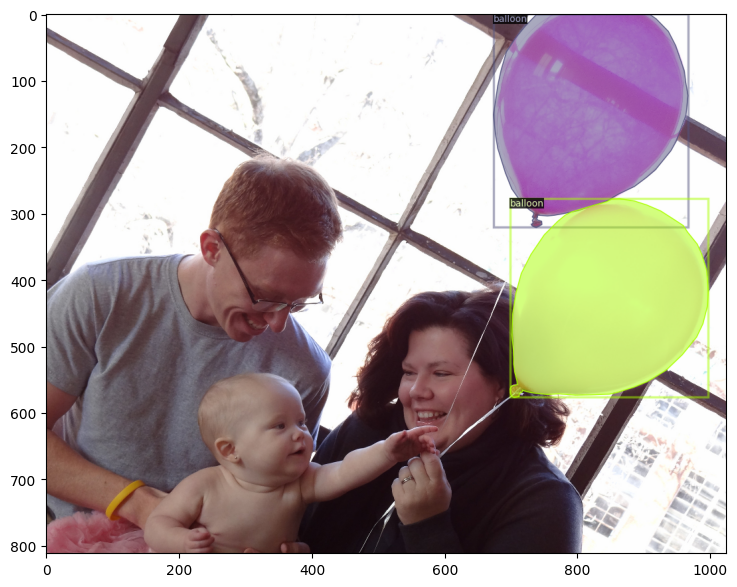

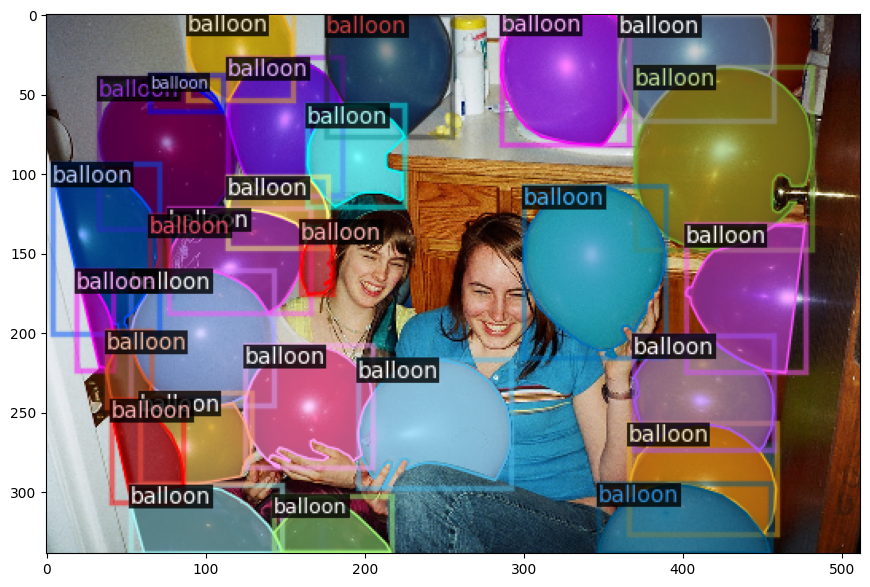

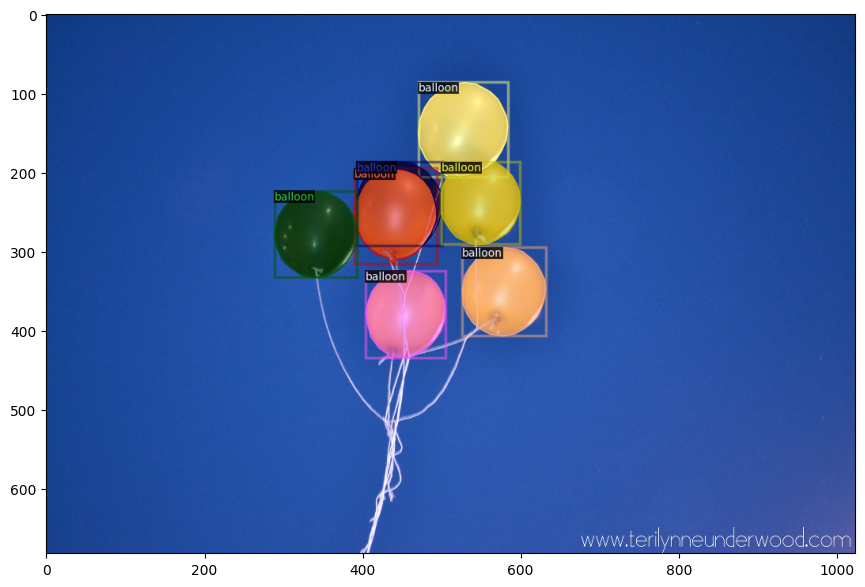

In [20]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

Since the our new data looks good. Let's now train our model!

As initial weights we'll use the pretrained weights from a model from the modelzoo. After finishing setting up the config we'll use the [**DefaultTrainer()**](https://detectron2.readthedocs.io/en/latest/modules/utils.html#module-detectron2.utils.visualizer) class to train our model!

More information about updating the config-file can be found [here](https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets).

In [23]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3    # 300 iterations enough for this dataset; Train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, enough for this dataset (default: 512)
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # one class (ballon). 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

c:\Users\M\Documents\LifeLongLearning\ai_projects\detectron2\detectron2\model_zoo\configs\COCO-InstanceSegmentation\mask_rcnn_R_50_FPN_3x.yaml
[06/26 11:27:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[06/26 11:27:48 d2.engine.train_loop]: Starting training from iteration 0
[06/26 11:29:38 d2.utils.events]:  eta: 0:00:00  iter: 2  total_loss: 2.052  loss_cls: 0.7244  loss_box_reg: 0.5754  loss_mask: 0.6931  loss_rpn_cls: 0.04792  loss_rpn_loc: 0.004546    time: 29.1664  last_time: 29.1664  data_time: 3.5362  last_data_time: 0.0085   lr: 0.00016675  
[06/26 11:29:39 d2.engine.hooks]: Overall training speed: 1 iterations in 0:00:29 (29.1665 s / it)
[06/26 11:29:39 d2.engine.hooks]: Total training time: 0:00:31 (0:00:02 on hooks)


Tensorboard usable in kaggle?

In [24]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir logs

*Note: I suppose TensorBoard doesn't work on Kaggle?*

<a id="modelevaluation" ></a>
## 4.4. Model evaluation
Let's check out the performance of our model!

First of all let's make some predictions! We're going to use the [**DefaultPredictor**](https://detectron2.readthedocs.io/en/latest/modules/engine.html?highlight=DefaultPredictor#detectron2.engine.defaults.DefaultPredictor) class. Ofcourse we'll use the same cfg that we used during training. We'll change two parameters for our inferencing.

In [25]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a testing threshold
predictor = DefaultPredictor(cfg)

[06/26 11:32:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


Notice that by using the [**ColorMode.IMAGE_BW**](https://detectron2.readthedocs.io/en/latest/modules/utils.html?highlight=ColorMode#module-detectron2.utils.visualizer) we we're capable of removing the colors from objects which aren't detected!

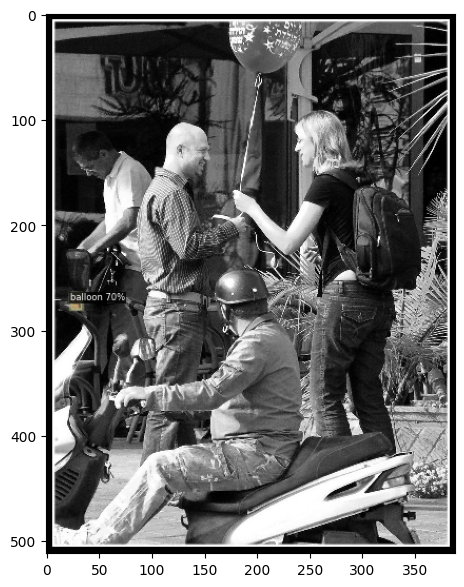

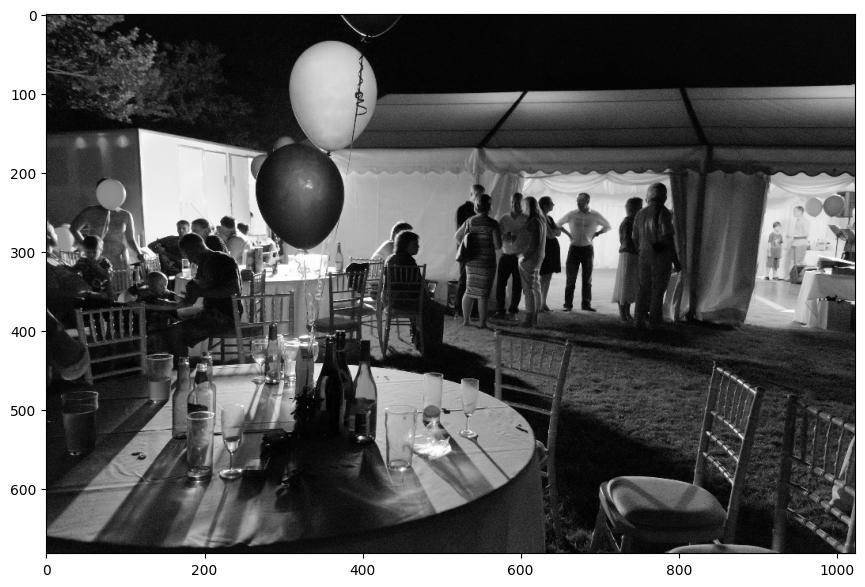

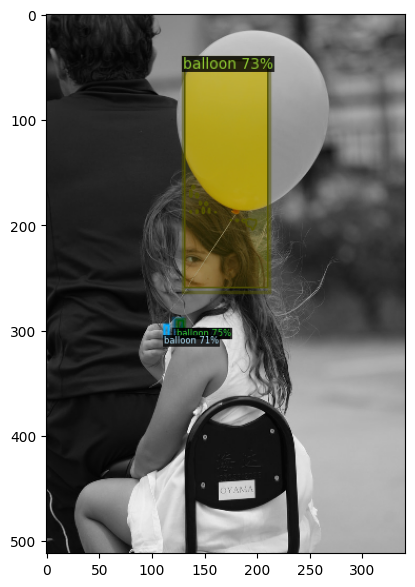

In [26]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. Only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

Above we can see that our models performs pretty well! Let's now evaluate our custom model with [Evaluators](https://detectron2.readthedocs.io/en/latest/modules/engine.html?highlight=DefaultPredictor#detectron2.engine.defaults.DefaultPredictor). Two evaluators can be used:
* [**COCOEvaluator**](https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#detectron2.evaluation.COCOEvaluator) can evaluate AP (Average Precision) for box detection, instance segmentation and keypoint detection.
* [**SemSegEvaluator**](https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#detectron2.evaluation.SemSegEvaluator) can evaluate semantic segmentation metrics.

Afterwards we'll use the [**build_detection_test_loader**](https://detectron2.readthedocs.io/en/latest/modules/data.html?highlight=build_detection_test_loader#detectron2.data.build_detection_test_loader) which returns a torch DataLoader, that loads the given detection dataset.

At last we'll use the model, evaluated and dataloader within the [inference_on_dataset](https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#detectron2.evaluation.inference_on_dataset) function. It runs the model on the dataloader and evaluates the metric with the evaluator.

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[06/26 11:33:31 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[06/26 11:33:31 d2.evaluation.coco_evaluation]: Trying to convert 'balloon_val' to COCO format ...
[06/26 11:33:31 d2.data.datasets.coco]: Converting annotations of dataset 'balloon_val' to COCO format ...)
[06/26 11:33:31 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/26 11:33:31 d2.data.datasets.coco]: Conversion finished, #images: 13, #annotations: 50
[06/26 11:33:31 d2.data.datasets.coco]: Caching COCO format annotations at './output/balloon_val_coco_format.json' ...
[06/26 11:33:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[06/26 11:33:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/26 

<a id="othermodels" ></a>
# 5. Other models

It's possible to use other high-end object detection models aswell. Let's check it out!

<a id="keypoint" ></a>
## 5.1. Keypoint detection

Reload the data.

In [18]:
!wget http://images.cocodataset.org/val2017/000000282037.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

model_final_a6e10b.pkl: 237MB [00:03, 73.8MB/s]                           


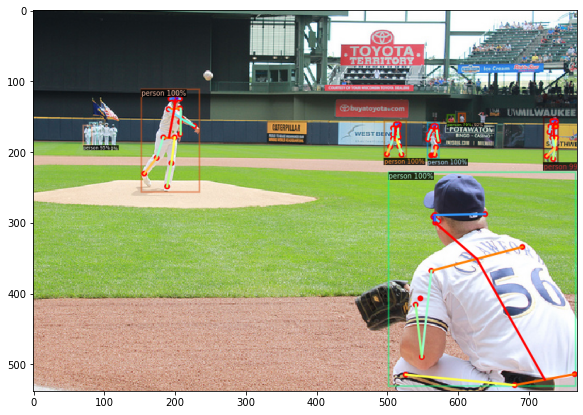

In [19]:
cfg = get_cfg()   # fresh config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(15,7))
plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

<a id="panoptic" ></a>
## 5.2. Panoptic segmentation

In [20]:
!wget http://images.cocodataset.org/val2017/000000282037.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

model_final_cafdb1.pkl: 261MB [00:03, 68.7MB/s]                           


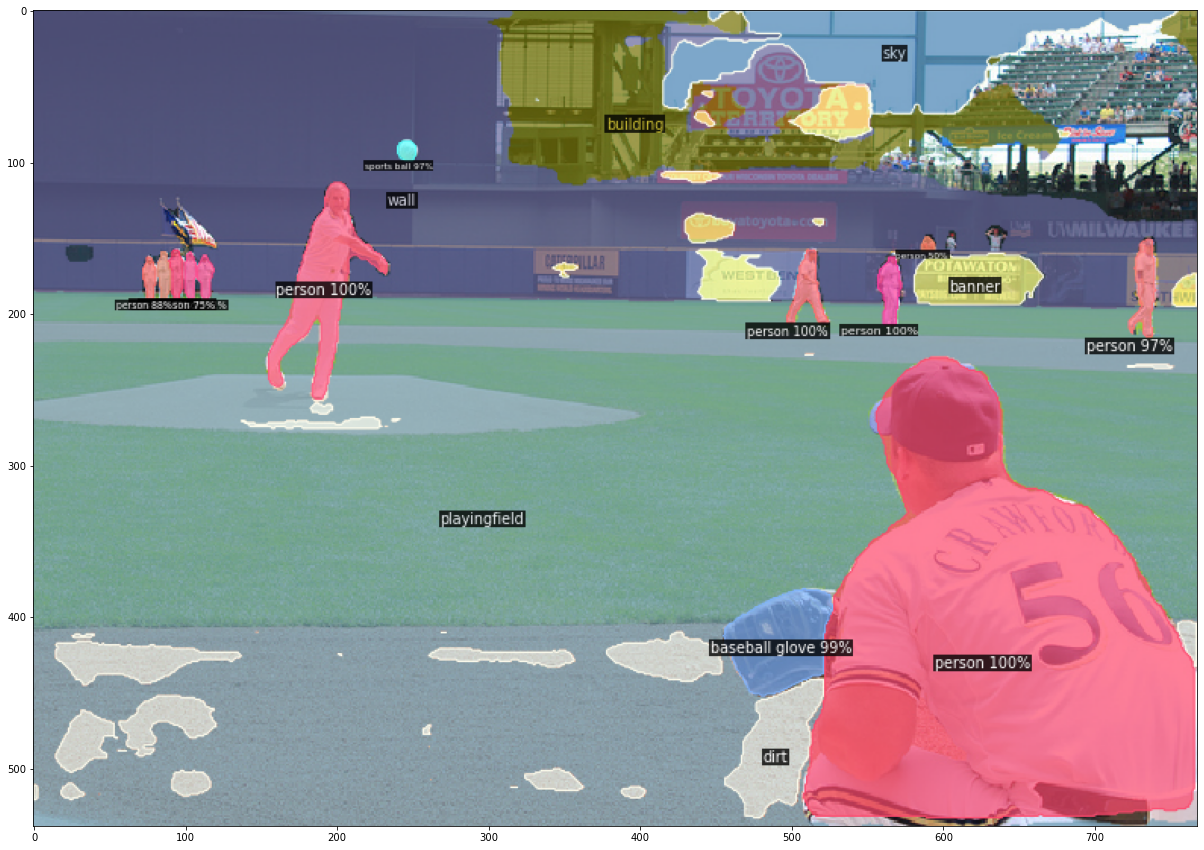

In [21]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.figure(figsize=(25,15))
plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

<a id="semantic" ></a>
## 5.3. Semantic, Densepose, ...

Will be added in a future version! Stay tuned!

<a id="video" ></a>
# 6. Video

So up until now we've been working with images only. Can we quickly use the models for videos? The answer is YES!

<a id="videolib" ></a>
## 6.1. Libraries
As you can see we actually don't need many other libraries. Lets import a library to handle the video.

In [22]:
from IPython.display import YouTubeVideo, display, Video # for viewing the video
!pip install youtube-dl # for downloading the video

     |████████████████████████████████| 1.9 MB 125 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<a id="thevideo" ></a>
## 6.2. The video

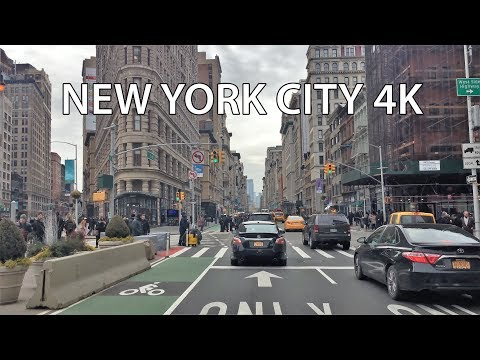

In [23]:
#video = YouTubeVideo("ll8TgCZ0plk", width=500)#7HaJArMDKgI
video = YouTubeVideo("7HaJArMDKgI", width=750, height= 450)#
display(video)

Downloading the video and cropping 6 seconds for processing


In [24]:
!youtube-dl https://www.youtube.com/watch?v=7HaJArMDKgI -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:10 -c:v copy video-clip.mp4 

[youtube] 7HaJArMDKgI: Downloading webpage
[download] Destination: video.mp4
[download] 100% of 1.13GiB in 00:27
ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4. 

<a id="videoinference" ></a>
## 6.3. Inference on the video
Let's now run an panoptic model over the video above.

*note: For now I'll be using some [demo](https://github.com/facebookresearch/detectron2/tree/master/demo) files, I'll later add the code implementations to this notebook.*

In [25]:
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output 1video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

Cloning into 'detectron2'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 10241 (delta 28), reused 45 (delta 21), pack-reused 10154
Receiving objects: 100% (10241/10241), 4.26 MiB | 9.28 MiB/s, done.
Resolving deltas: 100% (7395/7395), done.
[02/11 21:11:55 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml', input=None, opts=['MODEL.WEIGHTS', 'detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl'], output='1video-output.mkv', video_input='video-clip.mp4', webcam=False)
[02/11 21:11:58 fvcore.common.checkpoint]: Loading checkpoint from detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl
[02/11 21:11:58 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
Could not find encoder for codec id 27: 

Let's check the result! 

*I've ran into some trouble with video encoding opencv and ffmpeg (fix in future version of this notebook).*

In [26]:
!git clone https://github.com/vandeveldemaarten/tempdetector2video.git
Video("./tempdetector2video/myvideo.mkv")

Cloning into 'tempdetector2video'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


# That's all for now!

Thank you for reading this notebook! If you enjoyed it, please upvote!

*More coming soon!*